# Create inset overview figure for Introduction Section

In [204]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import numpy as np
import contextily as cx
import cartopy.io.img_tiles as cimgt

In [205]:
# Interesting links
'''
https://www.theurbanist.com.au/2021/03/plotting-openstreetmap-images-with-cartopy/
http://earthpy.org/cartopy_backgroung.html
https://unidata.github.io/python-training/gallery/mapping_goes16_truecolor/
https://semba-blog.netlify.app/07/04/2020/mapping-with-cartopy-in-python/
https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy
https://nasa-gibs.github.io/gibs-api-docs/access-basics/#ogc-web-map-tile-service-wmts
'''

# Find appopriate projection for the area of interest extent
#       https://projectionwizard.org/

'\nhttps://www.theurbanist.com.au/2021/03/plotting-openstreetmap-images-with-cartopy/\nhttp://earthpy.org/cartopy_backgroung.html\nhttps://unidata.github.io/python-training/gallery/mapping_goes16_truecolor/\nhttps://semba-blog.netlify.app/07/04/2020/mapping-with-cartopy-in-python/\nhttps://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy\nhttps://nasa-gibs.github.io/gibs-api-docs/access-basics/#ogc-web-map-tile-service-wmts\n'

## 1. Using WMS service

In [300]:
wms_urls = ['https://firms.modaps.eosdis.nasa.gov/mapserver/usfs/wms-info/#firms-wms',
            'https://neo.gsfc.nasa.gov/wms/wms',
            'https://ows.terrestris.de/osm/service',
            'https://www.gebco.net/data_and_products/gebco_web_services/web_map_service/mapserv?request=getcapabilities&service=wms&version=1.3.0',
            'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?',
            'https://www.gmrt.org/services/mapserver/wms_merc?request=GetCapabilities&service=WMS&version=1.3.0']

In [304]:
from owslib.wms import WebMapService

#Select url index
url_ix = -2

#create owslib instance and request url
wms = WebMapService(wms_urls[url_ix])
layers = np.array(list(wms.contents))
print(f'WMS url: {wms_urls[url_ix]}')
print('   wms type:', wms.identification.type)
print('   wms title:', wms.identification.title)
print('   wms layers:')
l = [print('   ',layer) for layer in np.sort(layers)]

WMS url: https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?
   wms type: OGC:WMS
   wms title: NASA Global Imagery Browse Services for EOSDIS
   wms layers:
    AIRS_L2_Carbon_Monoxide_500hPa_Volume_Mixing_Ratio_Day
    AIRS_L2_Carbon_Monoxide_500hPa_Volume_Mixing_Ratio_Night
    AIRS_L2_Cloud_Top_Height_Day
    AIRS_L2_Cloud_Top_Height_Night
    AIRS_L2_Dust_Score_Day
    AIRS_L2_Dust_Score_Night
    AIRS_L2_Methane_400hPa_Volume_Mixing_Ratio_Day
    AIRS_L2_Methane_400hPa_Volume_Mixing_Ratio_Night
    AIRS_L2_RelativeHumidity_500hPa_Day
    AIRS_L2_RelativeHumidity_500hPa_Night
    AIRS_L2_RelativeHumidity_700hPa_Day
    AIRS_L2_RelativeHumidity_700hPa_Night
    AIRS_L2_RelativeHumidity_850hPa_Day
    AIRS_L2_RelativeHumidity_850hPa_Night
    AIRS_L2_Sulfur_Dioxide_Brightness_Temperature_Difference_Day
    AIRS_L2_Sulfur_Dioxide_Brightness_Temperature_Difference_Night
    AIRS_L2_Surface_Air_Temperature_Day
    AIRS_L2_Surface_Air_Temperature_Night
    AIRS_L2_Surface_Relativ

In [305]:
# Find specific layers 
layers[np.core.defchararray.find(layers, 'Blue') != -1]

array(['Blue Marble', 'BlueMarble_NextGeneration',
       'BlueMarble_ShadedRelief', 'BlueMarble_ShadedRelief_Bathymetry',
       'MODIS_Aqua_AOD_Deep_Blue_Combined',
       'MODIS_Aqua_AOD_Deep_Blue_Land',
       'MODIS_Terra_AOD_Deep_Blue_Combined',
       'MODIS_Terra_AOD_Deep_Blue_Land',
       'VIIRS_SNPP_Angstrom_Exponent_Deep_Blue_Best_Estimate',
       'VIIRS_SNPP_AOT_Deep_Blue_Best_Estimate',
       'VIIRS_SNPP_Aerosol_Type_Deep_Blue_Best_Estimate'], dtype='<U75')

In [309]:
ix = np.where(layers=='BlueMarble_NextGeneration')[0][0]

In [310]:
#Select layer to use

layer_name = layers[ix]

print(f'WMS layer: {layer_name}')
print('  Styles: ', wms[layer_name].styles)
print('  BBox: ', wms[layer_name].boundingBox)
print('  BBox WGS84: ', wms[layer_name].boundingBoxWGS84)
print('  CRS options: ', wms[layer_name].crsOptions)
print('  WMS operations', [op.name for op in wms.operations])
      
wms.getOperationByName('GetCapabilities').methods

WMS layer: BlueMarble_NextGeneration
  Styles:  {}
  BBox:  (-180.0, -90.0, 180.0, 90.0, 'EPSG:4326')
  BBox WGS84:  (-180.0, -90.0, 180.0, 90.0)
  CRS options:  ['epsg:3857', 'epsg:4326', 'EPSG:4326']
  WMS operations ['GetCapabilities', 'GetMap']


[{'type': 'Get',
  'url': 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?'},
 {'type': 'Post',
  'url': 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?'}]

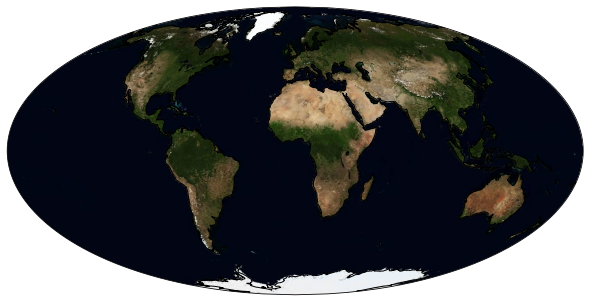

In [311]:
## option1 - Download wms and plot

import io
from IPython.display import Image

#Download
response = wms.getmap(layers=[layer_name,],
                 styles=['default'],
                 bbox=(-180, -90, 180, 90), # Left, bottom, right, top
                 format='image/png',
                 size=(600,600),
                 srs='EPSG:4326',
                 #time='2018-09-16',
                 transparent=True)

#Read
Image(response.read())

image = io.BytesIO(response.read())
data = plt.imread(image)

#Plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1], projection=ccrs.Mollweide())
ax.imshow(data, origin="upper", extent=(-180, 180, -90, 90),
          transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

/Users/govorcin/insar/miniconda3/envs/insar/lib/python3.7/site-packages/cartopy/io/ogc_clients.py:165: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in polys:


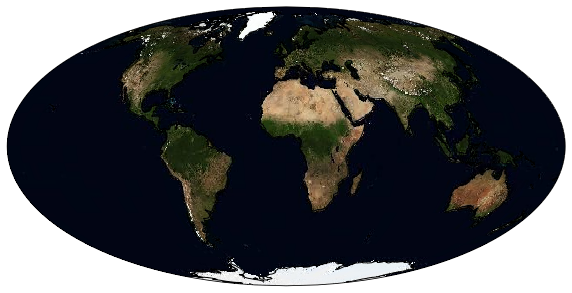

In [312]:
# Option 2 - use cartopy wms service based on owslib

# Using cartopy add_wms

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.Mollweide()}, figsize=(10, 10))
#ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add WMS imaging.
ax.add_wms(wms, layers=layer_name)
ax.coastlines()

## 2. Using WMTS cartopy service

In [313]:
from cartopy.io.img_tiles import GoogleTiles


print('urls provides:')
l = [print('  ', url) for url in cx.providers]


### Other links QuickMap
# https://qms.nextgis.com/#
#
wmts_urls = ['https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
             'http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}']

urls provides:
   OpenStreetMap
   OpenSeaMap
   OPNVKarte
   OpenTopoMap
   OpenRailwayMap
   OpenFireMap
   SafeCast
   Stadia
   Thunderforest
   CyclOSM
   Jawg
   MapBox
   MapTiler
   Stamen
   TomTom
   Esri
   OpenWeatherMap
   HERE
   HEREv3
   FreeMapSK
   MtbMap
   CartoDB
   HikeBike
   BasemapAT
   nlmaps
   NASAGIBS
   NLS
   JusticeMap
   GeoportailFrance
   OneMapSG
   USGS
   WaymarkedTrails
   OpenAIP
   OpenSnowMap
   AzureMaps
   SwissFederalGeoportal
   Gaode
   Strava


In [314]:
# Let try with ESRI

layer_esri = cx.providers.Esri.WorldImagery['variant']
url_esri = cx.providers.Esri.WorldImagery['url'].replace('{variant}', layer_esri)


#layer_google = cx.providers.Esri.WorldImagery['variant']
url_google = wmts_urls[0]
layer_google = 'Google Satelite'

Text(0.5, 1.0, 'Google Satelite')

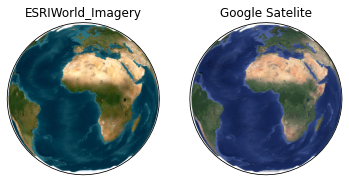

In [319]:
# PLOT

zoom_level = 5

#figure
fig, ax = plt.subplots(1,2, subplot_kw={'projection': ccrs.Orthographic()})
[lon0,lat0, lon1, lat1] = [-180, -90, 180, 90]

#Esri
#ax.set_extent([lon0, lat1, lat0, lat1])

image = cimgt.GoogleTiles(url = url_esri)
ax[0].add_image(image, zoom_level, cmap='gray')
ax[0].set_title('ESRI' + layer_esri)

#Google
#ax.set_extent([lon0, lat1, lat0, lat1])

image = cimgt.GoogleTiles(url = url_google)
ax[1].add_image(image, zoom_level, cmap='gray')
ax[1].set_title(layer_google)

## 3.  Create inset image

In [320]:
# load or define aoi

#load shapefile
import shapefile

#shape = shapefile.Reader("my_shapefile.shp")

#Define aoi
from shapely.geometry import Polygon

aoi = [-127, -113, 33, 46]
aoi_polygon = Polygon([[aoi[0], aoi[2]], 
                       [aoi[1], aoi[2]], 
                       [aoi[1], aoi[3]], 
                       [aoi[0], aoi[3]]])

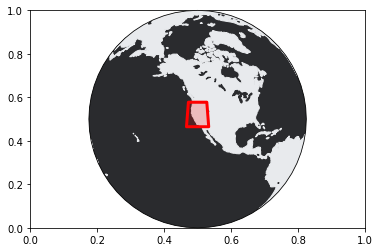

In [348]:
output_name = 'Inset'

simple_map = True
plot_aoi = True

# Define
extent = [-127, -113, 24, 50.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#central_lon = -10
#central_lat = 32


#Figure
fig_inset, ax = plt.subplots(1)
ortho = ccrs.Orthographic(central_lon, central_lat)
geo = ccrs.Geodetic()

ax = plt.axes(projection=ortho)

# Plot cartopy fetaure

if simple_map:
    ax.coastlines(edgecolor='#E8EAED', linewidth=0.2, zorder=1)
    #rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')

    ax.add_feature(cfeature.OCEAN, facecolor='#2A2B2E',zorder=0)
    ax.add_feature(cfeature.LAND, edgecolor='#E8EAED', facecolor='#E8EAED', zorder=1)
    ax.add_feature(cfeature.LAKES, facecolor='#2A2B2E', zorder=1)
    #ax.add_feature(cfeature.STATES, linewidth=0.01)
    #ax.add_feature(cfeature.RIVERS)
    #ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
    #ax.gridlines()
else:
    # Plot basemap
    #ax.add_wmts(wms, layer_name, zorder=1, alpha = 0.9) # wmts tiled
    ax.add_wms(wms, layer_name, zorder=1, alpha = 0.9) # wms


# Plot AOI
if plot_aoi:
    ax.add_geometries([aoi_polygon], 
                      crs=ccrs.Geodetic(),
                      linewidth=1,
                      zorder=3,
                      facecolor='red', 
                      edgecolor='red', 
                      alpha=0.2)

    ax.add_geometries([aoi_polygon], 
                      crs=ccrs.Geodetic(),
                      linewidth=3,
                      zorder=3,
                      facecolor='none', 
                      edgecolor='red', 
                      alpha=1)
    

In [ ]:
#Save 
fig_inset.savefig(output_name + '.png', dpi=600, transparent=True)